In [26]:
import sys
sys.path.append('../')

In [27]:
from scripts.utils import data_path
from scripts.cross_match_scripts import build_keras_model, plot_metrics, assess_classifier, save_keras_classifier, assess_classifier, photo_prior_create_train_test_validation_data
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
pd.set_option('display.max_columns', 500)
import seaborn as sns
import numpy as np
import pickle
%matplotlib inline
photo_cat_scaled = pd.read_pickle('model/train_test_validation_data.pkl')

load_models = True


# Classification model: Keras - Sequential neural network

## GRZW1W2 data - baseline model

In [28]:
learning_dict = photo_prior_create_train_test_validation_data(photo_cat_scaled=photo_cat_scaled, features_cols = 'grzw1w2')

total x-ray sources:  10480
total non-x-ray sources:  55636
total sources:  66116
number of x-ray sources per flux bin:
x_ray_flux_bin
0    10480
dtype: int64
number of non-x-ray sources per flux bin:
x_ray_flux_bin
0    55636
dtype: int64
x-ray flux bins:
[3.00076359e-15 3.92776796e-12]
********************
flux bin:  3.0007635913564e-15 3.927767961003e-12
train features: 
  ['rel_dered_mag_g', 'rel_dered_mag_r', 'rel_dered_mag_z', 'rel_dered_mag_w1', 'rel_dered_mag_w2', 'rel_dered_g_r', 'rel_dered_r_z', 'rel_dered_g_z', 'rel_dered_z_w1', 'rel_dered_r_w2', 'rel_dered_w1_w2']
train size examples - filed:  31156
train size examples - x-ray: 5869
test size examples - filed:  7790
test size examples - x-ray 1467
validation size examples - filed:  16690
validation size examples - x-ray: 3144
downsampled field sources:  False
data is scaled


In [29]:
X_train, y_train, X_test, y_test, X_val, y_val, class_weight_train = learning_dict[0]['X_train'], learning_dict[0]['y_train'], learning_dict[0]['X_test'], learning_dict[0]['y_test'], learning_dict[0]['X_val'], learning_dict[0]['y_val'], learning_dict[0]['class_weight_train']
initial_bias = np.log([np.sum(y_test)/np.sum(~y_test)])

model_grzw1w2, early_stopping = build_keras_model(input_features_shape=X_train.shape[1],
                                    activation='tanh',
                                    layers_num=(8,8,8,8),
                                    dropout_rate=0.1,
                                    initial_bias=initial_bias,)


if load_models:
    model_grzw1w2 = tf.keras.models.load_model('model/nnmag_grzw1w2.keras_nn')
    history_grzw1w2 =  pickle.load(open('model/nnmag_grzw1w2.keras_nn/history', "rb"))
    history_grzw1w2['epoch'] = np.arange(len(history_grzw1w2['loss']))

#tf.keras.utils.plot_model(model_grzw1w2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 8)                 96        
                                                                 
 dense_19 (Dense)            (None, 8)                 72        
                                                                 
 dropout_10 (Dropout)        (None, 8)                 0         
                                                                 
 dense_20 (Dense)            (None, 8)                 72        
                                                                 
 dropout_11 (Dropout)        (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 8)                 72        
                                                                 
 dropout_12 (Dropout)        (None, 8)                

In [30]:
if not load_models:

    history_grzw1w2 = model_grzw1w2.fit(
    X_train,
    y_train,
    batch_size=500,
    epochs=150,
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping],
    class_weight=class_weight_train,
    verbose=0)

    with open('model/nnmag_grzw1w2.keras_nn/history', 'wb') as file_pi:
        pickle.dump(history_grzw1w2.history, file_pi)




Optimal threshold: 0.83
Optimal precision: 0.67


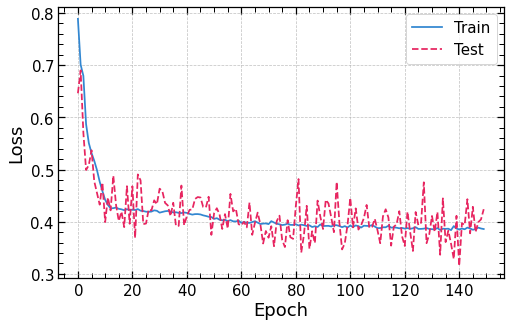

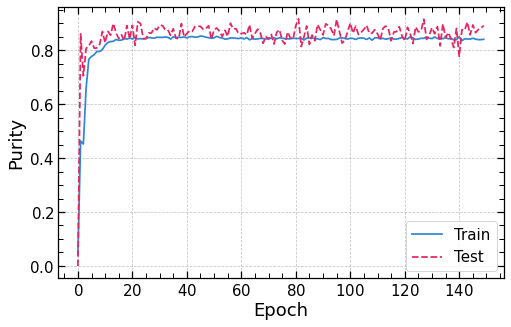

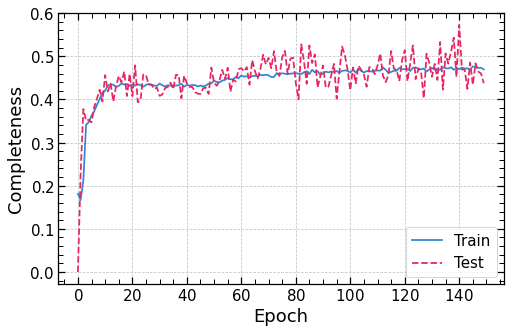

<Figure size 360x360 with 0 Axes>

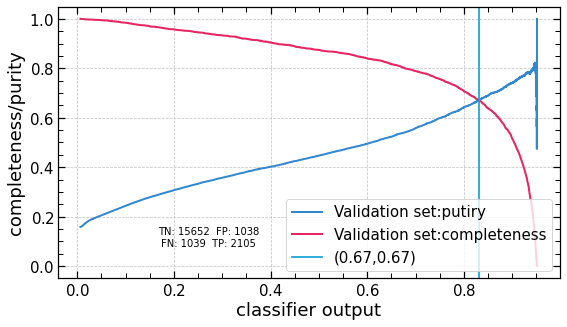

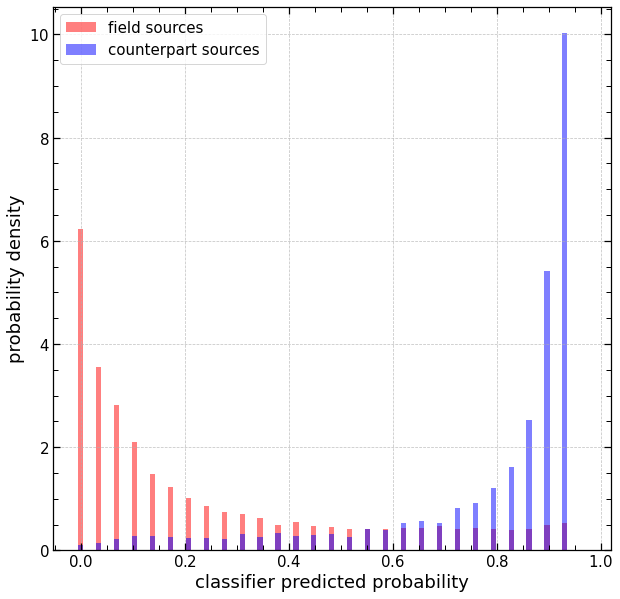

In [31]:
plot_metrics(history_grzw1w2)
_,_,_, hist_df = assess_classifier(model_grzw1w2, X_val, y_val);

if not load_models: save_keras_classifier(model_grzw1w2, hist_df, 'model/nnmag_grzw1w2')


figure for paper

Optimal threshold: 0.83
Optimal precision: 0.67


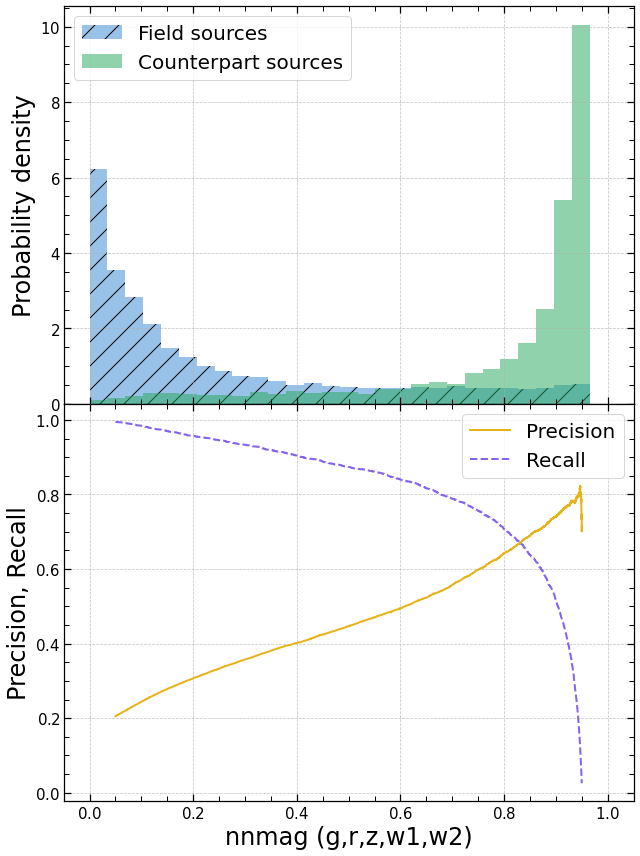

In [32]:
import sklearn
histbins = 30

try:
    predict_proba = model_grzw1w2.predict_proba(X_val)[:,1]
except:
    #add predict_proba for consistency with sklearn
    model_grzw1w2.predict_proba = lambda X: np.vstack((np.ones(X.shape[0]), model_grzw1w2.predict(X, verbose = 0)[:,0])).T
    predict_proba = model_grzw1w2.predict_proba(X_val)[:,1]


precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_val, predict_proba)
precision = precision[:-1]
recall = recall[:-1]

recall = recall[(thresholds>0.05) & (thresholds<0.95)]
precision = precision[(thresholds>0.05) & (thresholds<0.95)]
thresholds = thresholds[(thresholds>0.05) & (thresholds<0.95)]
#recall is TP / (TP + FN) - We know it as  completeness  -> number of true positives / all positives
#precision is TP / (TP + FP) - We know it as purity -> number of samples that are correctly classified out of all classified samples


fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': None}, figsize = (9,12))
ax2, ax1 = axs
ax1.plot(thresholds, precision , 'C4-', label='Precision', linewidth=2)
ax1.plot(thresholds,recall ,  'C3--',label='Recall', linewidth=2)
ax1.set_xlabel('nnmag (g,r,z,w1,w2)', fontsize = 24)
ax1.set_ylabel('Precision, Recall', fontsize = 24)
plt.grid(True)
id_optim = np.argmin(np.abs(precision-recall))
threshold_optim = thresholds[id_optim]
precision_optim = precision[id_optim]
recall_optim = recall[id_optim]
print('Optimal threshold: {:.2f}'.format(threshold_optim))
print('Optimal precision: {:.2f}'.format(precision_optim))
#ax1.axvline(threshold_optim, color='C5', label = f"({precision_optim:.2f},{recall_optim:.2f})")

cm = sklearn.metrics.confusion_matrix(y_val, predict_proba > threshold_optim)

cm_str = f"TN: {cm[0,0]}  FP: {cm[0,1]}\nFN: {cm[1,0]}  TP: {cm[1,1]}"
#add a string version of the confusion matrix, add true positive , false positive  etc labels

#ax.text(0.3, 0.15, cm_str, ha='center', va='center', transform=ax.transAxes)
ax1.legend(fontsize = 20)


y_val = np.reshape(y_val, (-1,))
bins = np.linspace(0, 1, histbins)
hist_field, bin_field = np.histogram(predict_proba[y_val==0], bins=bins, density=True)  
hist_ctsp, bin_ctsp = np.histogram(predict_proba[y_val==1], bins=bins, density=True)


#ax2.bar(bin_field[:-1], hist_field, width=0.01, color='C0', label='field sources', alpha = 0.5)
ax2.hist(predict_proba[y_val==0], bins=bins, color='C0', label='Field sources', density=True, alpha = 0.5, hatch='/')
ax2.hist(predict_proba[y_val==1], bins=bins, color='C2', label='Counterpart sources', density=True, alpha = 0.5)
ax2.legend(fontsize = 20)
ax2.set_xlabel('nnmag (g,r,z,w1,w2)', fontsize = 24)
ax2.set_ylabel('Probability density', fontsize = 24)
fig.tight_layout()

plt.savefig(data_path+'/paper_plots/nnmag_dist_grzw1w2.pdf')




## GRZW1 data - worser baseline model

In [33]:
learning_dict = photo_prior_create_train_test_validation_data(photo_cat_scaled=photo_cat_scaled, features_cols = 'grzw1')

total x-ray sources:  10814
total non-x-ray sources:  89670
total sources:  100484
number of x-ray sources per flux bin:
x_ray_flux_bin
0    10814
dtype: int64
number of non-x-ray sources per flux bin:
x_ray_flux_bin
0    89670
dtype: int64
x-ray flux bins:
[3.00076359e-15 3.92776796e-12]
********************
flux bin:  3.0007635913564e-15 3.927767961003e-12
train features: 
  ['rel_dered_mag_g', 'rel_dered_mag_r', 'rel_dered_mag_z', 'rel_dered_mag_w1', 'rel_dered_g_r', 'rel_dered_r_z', 'rel_dered_g_z', 'rel_dered_z_w1']
train size examples - filed:  50215
train size examples - x-ray: 6056
test size examples - filed:  12554
test size examples - x-ray 1514
validation size examples - filed:  26901
validation size examples - x-ray: 3244
downsampled field sources:  False
data is scaled


In [34]:
X_train, y_train, X_test, y_test, X_val, y_val, class_weight_train = learning_dict[0]['X_train'], learning_dict[0]['y_train'], learning_dict[0]['X_test'], learning_dict[0]['y_test'], learning_dict[0]['X_val'], learning_dict[0]['y_val'], learning_dict[0]['class_weight_train']
initial_bias = np.log([np.sum(y_test)/np.sum(~y_test)])

model_grzw1, early_stopping = build_keras_model(input_features_shape=X_train.shape[1],
                                    activation='tanh',
                                    layers_num=(8,8,8,8),
                                    dropout_rate=0.1,
                                    initial_bias=initial_bias,)


if load_models:
    model_grzw1 = tf.keras.models.load_model('model/nnmag_grzw1.keras_nn')
    history_grzw1 =  pickle.load(open('model/nnmag_grzw1.keras_nn/history', "rb"))
    history_grzw1['epoch'] = np.arange(len(history_grzw1['loss']))

#tf.keras.utils.plot_model(model_grzw1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 8)                 72        
                                                                 
 dense_24 (Dense)            (None, 8)                 72        
                                                                 
 dropout_13 (Dropout)        (None, 8)                 0         
                                                                 
 dense_25 (Dense)            (None, 8)                 72        
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_26 (Dense)            (None, 8)                 72        
                                                                 
 dropout_15 (Dropout)        (None, 8)                

In [35]:
if not load_models:

    history_grzw1 = model_grzw1.fit(
    X_train,
    y_train,
    batch_size=500,
    epochs=150,
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping],
    class_weight=class_weight_train,
    verbose=0)

    with open('model/nnmag_grzw1.keras_nn/history', 'wb') as file_pi:
        pickle.dump(history_grzw1.history, file_pi)



Optimal threshold: 0.82
Optimal precision: 0.61


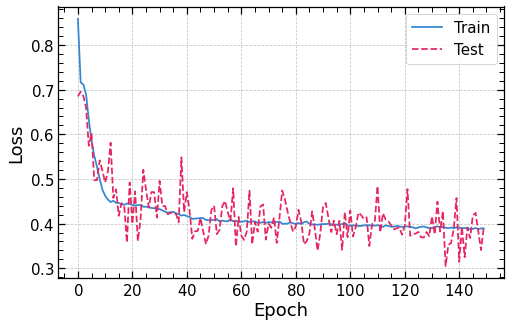

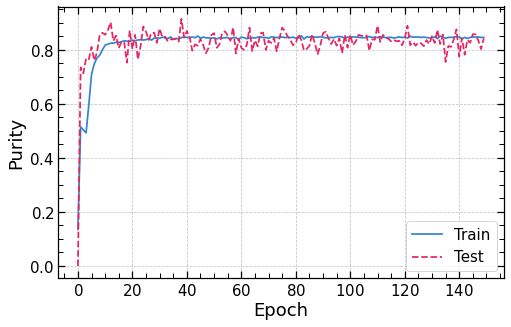

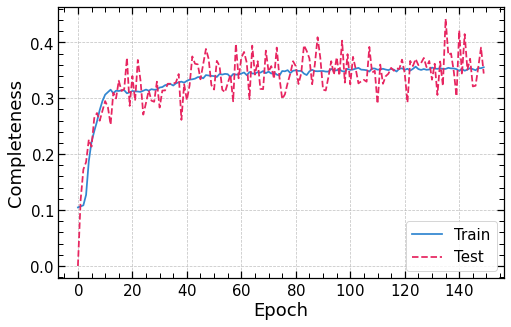

<Figure size 360x360 with 0 Axes>

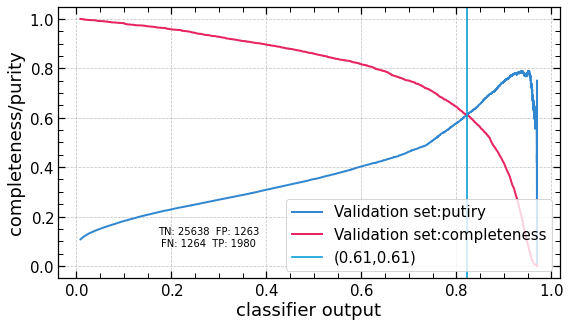

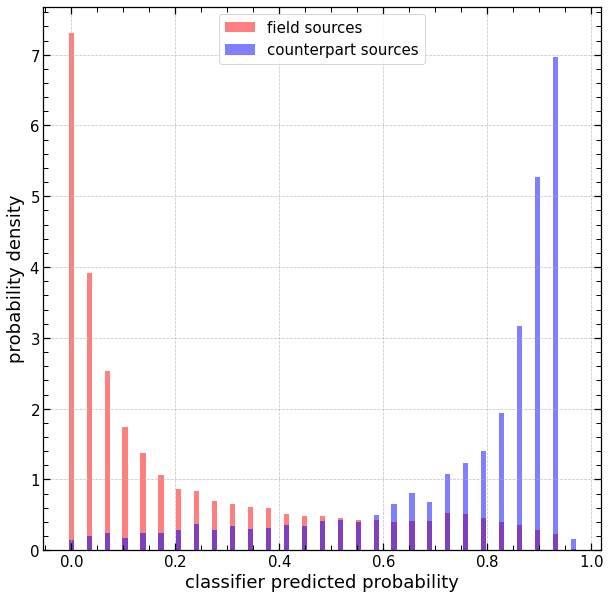

In [36]:
plot_metrics(history_grzw1)
_,_,_, hist_df = assess_classifier(model_grzw1, X_val, y_val);

if not load_models: save_keras_classifier(model_grzw1, hist_df, 'model/nnmag_grzw1')


Optimal threshold: 0.82
Optimal precision: 0.61


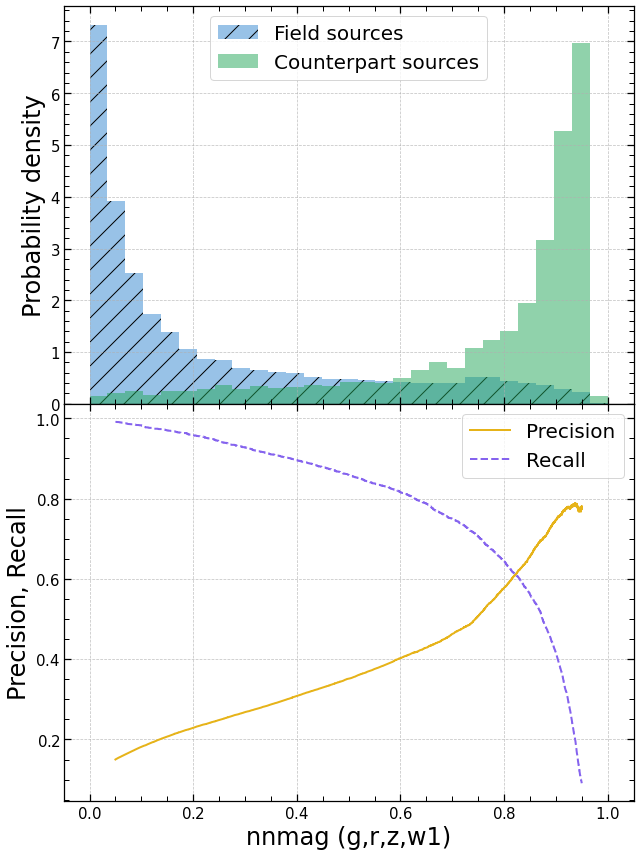

In [37]:
import sklearn
histbins = 30


try:
    predict_proba = model_grzw1.predict_proba(X_val)[:,1]
except:
    #add predict_proba for consistency with sklearn
    model_grzw1.predict_proba = lambda X: np.vstack((np.ones(X.shape[0]), model_grzw1.predict(X, verbose = 0)[:,0])).T
    predict_proba = model_grzw1.predict_proba(X_val)[:,1]


precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_val, predict_proba)
precision = precision[:-1]
recall = recall[:-1]

recall = recall[(thresholds>0.05) & (thresholds<0.95)]
precision = precision[(thresholds>0.05) & (thresholds<0.95)]
thresholds = thresholds[(thresholds>0.05) & (thresholds<0.95)]
#recall is TP / (TP + FN) - We know it as  completeness  -> number of true positives / all positives
#precision is TP / (TP + FP) - We know it as purity -> number of samples that are correctly classified out of all classified samples


fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': None}, figsize = (9,12))
ax2, ax1 = axs
ax1.plot(thresholds, precision , 'C4-', label='Precision', linewidth=2)
ax1.plot(thresholds,recall ,  'C3--',label='Recall', linewidth=2)
ax1.set_xlabel('nnmag (g,r,z,w1)', fontsize = 24)
ax1.set_ylabel('Precision, Recall', fontsize = 24)
plt.grid(True)
id_optim = np.argmin(np.abs(precision-recall))
threshold_optim = thresholds[id_optim]
precision_optim = precision[id_optim]
recall_optim = recall[id_optim]
print('Optimal threshold: {:.2f}'.format(threshold_optim))
print('Optimal precision: {:.2f}'.format(precision_optim))
#ax1.axvline(threshold_optim, color='C5', label = f"({precision_optim:.2f},{recall_optim:.2f})")

cm = sklearn.metrics.confusion_matrix(y_val, predict_proba > threshold_optim)

cm_str = f"TN: {cm[0,0]}  FP: {cm[0,1]}\nFN: {cm[1,0]}  TP: {cm[1,1]}"
#add a string version of the confusion matrix, add true positive , false positive  etc labels

#ax.text(0.3, 0.15, cm_str, ha='center', va='center', transform=ax.transAxes)
ax1.legend(fontsize = 20)


y_val = np.reshape(y_val, (-1,))
bins = np.linspace(0, 1, histbins)
hist_field, bin_field = np.histogram(predict_proba[y_val==0], bins=bins, density=True)  
hist_ctsp, bin_ctsp = np.histogram(predict_proba[y_val==1], bins=bins, density=True)


#ax2.bar(bin_field[:-1], hist_field, width=0.01, color='C0', label='field sources', alpha = 0.5)
ax2.hist(predict_proba[y_val==0], bins=bins, color='C0', label='Field sources', density=True, alpha = 0.5, hatch='/')
ax2.hist(predict_proba[y_val==1], bins=bins, color='C2', label='Counterpart sources', density=True, alpha = 0.5)
ax2.legend(fontsize = 20)
ax2.set_xlabel('nnmag (g,r,z,w1)', fontsize = 24)
ax2.set_ylabel('Probability density', fontsize = 24)
fig.tight_layout()

plt.savefig(data_path+'/paper_plots/nnmag_dist_grzw1.pdf')




## GRZ data - pessimistic model

In [38]:
learning_dict = photo_prior_create_train_test_validation_data(photo_cat_scaled=photo_cat_scaled, features_cols = 'grz')

total x-ray sources:  11092
total non-x-ray sources:  141845
total sources:  152937
number of x-ray sources per flux bin:
x_ray_flux_bin
0    11092
dtype: int64
number of non-x-ray sources per flux bin:
x_ray_flux_bin
0    141845
dtype: int64
x-ray flux bins:
[3.00076359e-15 3.92776796e-12]
********************
flux bin:  3.0007635913564e-15 3.927767961003e-12
train features: 
  ['rel_dered_mag_g', 'rel_dered_mag_r', 'rel_dered_mag_z', 'rel_dered_g_r', 'rel_dered_r_z', 'rel_dered_g_z']
train size examples - filed:  79433
train size examples - x-ray: 6211
test size examples - filed:  19859
test size examples - x-ray 1553
validation size examples - filed:  42553
validation size examples - x-ray: 3328
downsampled field sources:  False
data is scaled


In [39]:
X_train, y_train, X_test, y_test, X_val, y_val, class_weight_train = learning_dict[0]['X_train'], learning_dict[0]['y_train'], learning_dict[0]['X_test'], learning_dict[0]['y_test'], learning_dict[0]['X_val'], learning_dict[0]['y_val'], learning_dict[0]['class_weight_train']
initial_bias = np.log([np.sum(y_test)/np.sum(~y_test)])

model_grz, early_stopping = build_keras_model(input_features_shape=X_train.shape[1],
                                    activation='tanh',
                                    layers_num=(13,13),
                                    dropout_rate=0.0,
                                    initial_bias=initial_bias,)
#15,15 - 49%
#10,10 - 48%
#12, 12 - dropout 0.0 - 53%

if load_models:
    model_grz = tf.keras.models.load_model('model/nnmag_grz.keras_nn')
    history_grz =  pickle.load(open('model/nnmag_grz.keras_nn/history', "rb"))
    history_grz['epoch'] = np.arange(len(history_grz['loss']))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 13)                91        
                                                                 
 dense_29 (Dense)            (None, 13)                182       
                                                                 
 dropout_16 (Dropout)        (None, 13)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 14        
                                                                 
Total params: 287
Trainable params: 287
Non-trainable params: 0
_________________________________________________________________


In [40]:
if not load_models:
    history_grz = model_grz.fit(
    X_train,
    y_train,
    batch_size=500,
    epochs=150,
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping],
    class_weight=class_weight_train,
    verbose=0)
    

    with open('model/nnmag_grz.keras_nn/history', 'wb') as file_pi:
        pickle.dump(history_grz.history, file_pi)



Optimal threshold: 0.77
Optimal precision: 0.38


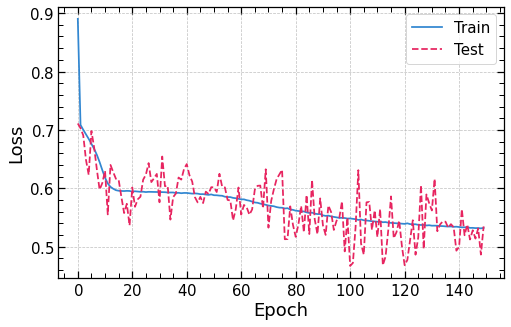

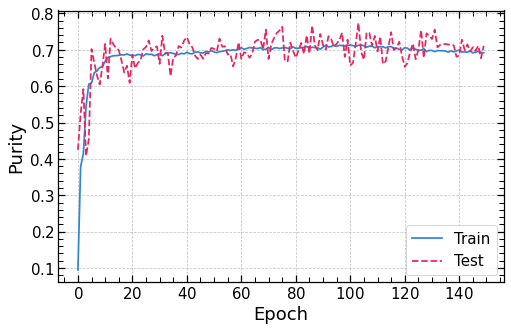

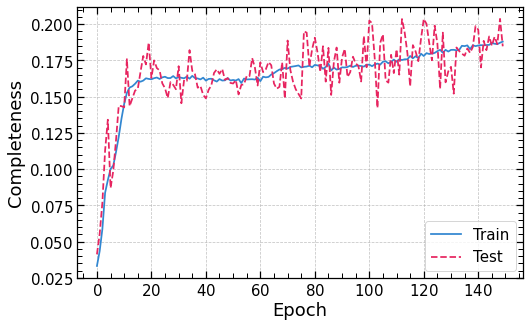

<Figure size 360x360 with 0 Axes>

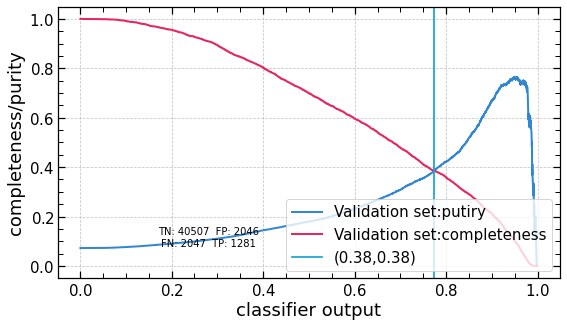

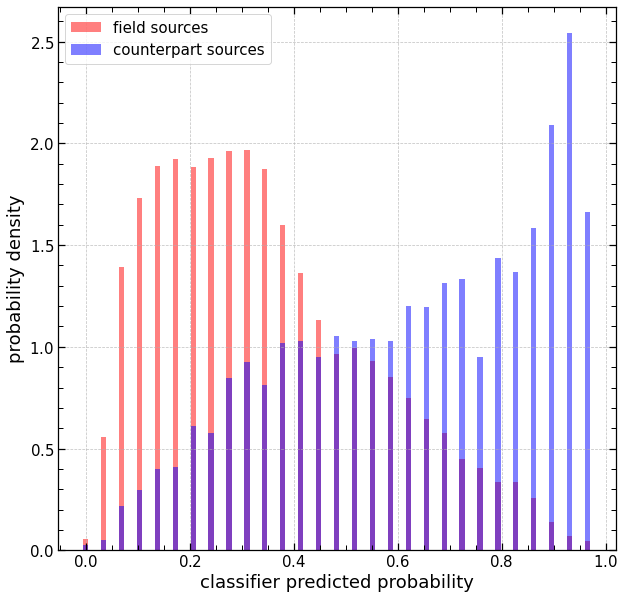

In [41]:
plot_metrics(history_grz)
_,_,_, hist_df = assess_classifier(model_grz, X_val, y_val);

if not load_models:  save_keras_classifier(model_grz, hist_df, 'model/nnmag_grz')


Optimal threshold: 0.77
Optimal precision: 0.38


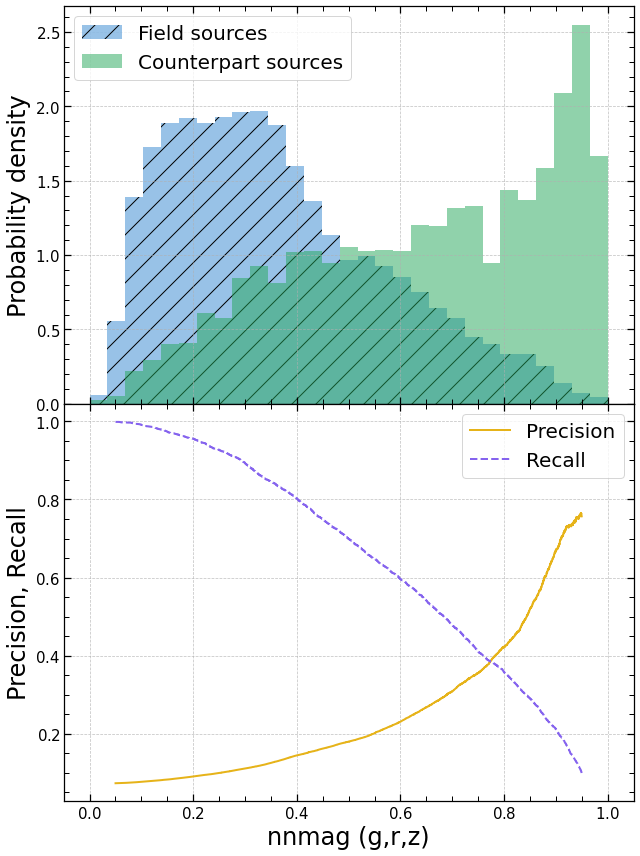

In [42]:
import sklearn
histbins = 30


try:
    predict_proba = model_grz.predict_proba(X_val)[:,1]
except:
    #add predict_proba for consistency with sklearn
    model_grz.predict_proba = lambda X: np.vstack((np.ones(X.shape[0]), model_grz.predict(X, verbose = 0)[:,0])).T
    predict_proba = model_grz.predict_proba(X_val)[:,1]


precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_val, predict_proba)
precision = precision[:-1]
recall = recall[:-1]

recall = recall[(thresholds>0.05) & (thresholds<0.95)]
precision = precision[(thresholds>0.05) & (thresholds<0.95)]
thresholds = thresholds[(thresholds>0.05) & (thresholds<0.95)]
#recall is TP / (TP + FN) - We know it as  completeness  -> number of true positives / all positives
#precision is TP / (TP + FP) - We know it as purity -> number of samples that are correctly classified out of all classified samples


fig, axs =  plt.subplots(nrows=2, ncols = 1, sharex = True, gridspec_kw = {'hspace':0, 'height_ratios': None}, figsize = (9,12))
ax2, ax1 = axs
ax1.plot(thresholds, precision , 'C4-', label='Precision', linewidth=2)
ax1.plot(thresholds,recall ,  'C3--',label='Recall', linewidth=2)
ax1.set_xlabel('nnmag (g,r,z)', fontsize = 24)
ax1.set_ylabel('Precision, Recall', fontsize = 24)
plt.grid(True)
id_optim = np.argmin(np.abs(precision-recall))
threshold_optim = thresholds[id_optim]
precision_optim = precision[id_optim]
recall_optim = recall[id_optim]
print('Optimal threshold: {:.2f}'.format(threshold_optim))
print('Optimal precision: {:.2f}'.format(precision_optim))
#ax1.axvline(threshold_optim, color='C5', label = f"({precision_optim:.2f},{recall_optim:.2f})")

cm = sklearn.metrics.confusion_matrix(y_val, predict_proba > threshold_optim)

cm_str = f"TN: {cm[0,0]}  FP: {cm[0,1]}\nFN: {cm[1,0]}  TP: {cm[1,1]}"
#add a string version of the confusion matrix, add true positive , false positive  etc labels

#ax.text(0.3, 0.15, cm_str, ha='center', va='center', transform=ax.transAxes)
ax1.legend(fontsize = 20)


y_val = np.reshape(y_val, (-1,))
bins = np.linspace(0, 1, histbins)
hist_field, bin_field = np.histogram(predict_proba[y_val==0], bins=bins, density=True)  
hist_ctsp, bin_ctsp = np.histogram(predict_proba[y_val==1], bins=bins, density=True)


#ax2.bar(bin_field[:-1], hist_field, width=0.01, color='C0', label='field sources', alpha = 0.5)
ax2.hist(predict_proba[y_val==0], bins=bins, color='C0', label='Field sources', density=True, alpha = 0.5, hatch='/')
ax2.hist(predict_proba[y_val==1], bins=bins, color='C2', label='Counterpart sources', density=True, alpha = 0.5)
ax2.legend(fontsize = 20)
ax2.set_xlabel('nnmag (g,r,z)', fontsize = 24)
ax2.set_ylabel('Probability density', fontsize = 24)
fig.tight_layout()

plt.savefig(data_path+'/paper_plots/nnmag_dist_grz.pdf')


